# G11 Ví dụ: Tornado plot

## Mục đích

Chúng ta sẽ vẽ một biểu đồ gọi là tornado plot. Nó là một dạng biểu đồ thanh ngang chồng lên nhau, nhưng được căn ở giữa để giúp việc so sánh nhị phân hóa. Qua đây chúng ta cũng sẽ ôn lại thao tác với Pandas.


## Kịch bản

Chúng ta tiến hành khảo sát trên 200 người (100 nữ, 100 nam) bằng một bộ câu hỏi có 7 câu hỏi về thói quen sức khỏe, mỗi câu hỏi có 4 lựa chọn: 1=Không bao giờ, 2=Thỉnh thoảng, 3=Khá thường xuyên, 4=Luôn luôn. Chúng ta muốn biểu diễn tổng hợp câu trả lời của 200 người này lên một biểu đồ.

Trước hết hãy xem số liệu.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def get_random_props():
    props = np.random.random(3) * .4
    if np.sum(props) > 1:
        props = np.array([.3, .2, .4])
    props = np.insert(props, 1, 1 - np.sum(props))
    return props

n = 100
np.random.seed(0)
columns = pd.MultiIndex.from_product([range(1, 8), ["Nam", "Nữ"]])

rand_props = map(lambda _: get_random_props(), range(14))

d = pd.DataFrame(dict(zip(
    columns,
    map(lambda x: np.random.choice([1, 2, 3, 4], size=n, replace=True, p=x), rand_props)
))).stack(1).rename(columns=lambda x: f"habit_{x}").rename_axis(index=["", "sex"]).reset_index("sex")
d["id"] = range(1, n * 2 + 1)
d.index = range(n * 2)
d.head(6)

,sex,habit_1,habit_2,habit_3,habit_4,habit_5,habit_6,habit_7,id
0,Nam,3,4,2,3,3,4,1,1
1,Nữ,2,2,2,2,3,4,3,2
2,Nam,2,4,2,3,3,4,2,3
3,Nữ,2,2,4,4,2,3,4,4
4,Nam,3,1,1,3,2,2,1,5
5,Nữ,1,3,2,4,2,2,3,6


Chúng ta có thể nhanh chóng tổng hợp lại số lượng (hoặc tỉ lệ phần trăm) các câu trả lời của mỗi thói quen này.

In [2]:
d_agg = d.melt(["id", "sex"], var_name="habit") \
    .pivot_table(values="id", index=["sex", "habit"], columns="value", aggfunc="count") \
    .fillna(0, downcast="infer") \
    .reset_index()
d_agg

value,sex,habit,1,2,3,4
0,Nam,habit_1,27,25,28,20
1,Nam,habit_2,29,30,15,26
2,Nam,habit_3,1,76,9,14
3,Nam,habit_4,22,30,38,10
4,Nam,habit_5,4,48,40,8
5,Nam,habit_6,23,36,3,38
6,Nam,habit_7,21,53,19,7
7,Nữ,habit_1,35,32,12,21
8,Nữ,habit_2,0,66,28,6
9,Nữ,habit_3,29,49,3,19


## Tornado plot

Biểu đồ thanh chồng nhau (stacked bar chart) là một loại biểu đồ phù hợp cho mục đích thể hiện trong này. Bạn có thể vẽ rất đơn giản bằng hàm `pandas.DataFrame.plot.barh()` với đối số `stacked=True`.

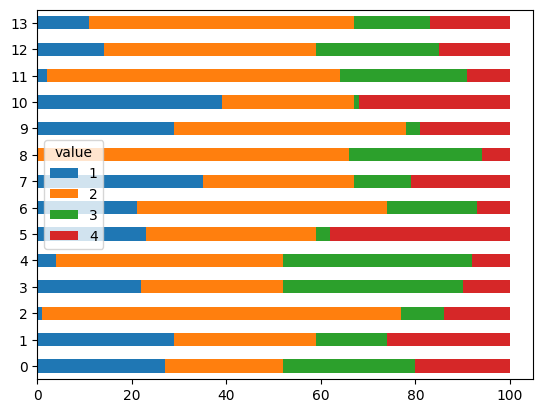

In [3]:
d_agg.plot.barh(stacked=True)
plt.show()

Tuy nhiên, chúng ta muốn một biểu đồ như sau:

* Mốc 0 của tất cả các thanh bắt đầu lựa chọn 3 (Khá thường xuyên). Hai lựa chọn 1 và 2 nằm về bên trái, và hai lựa chọn 3 và 4 nằm về bên phải.

* Hai thanh của nam và nữ nằm gần nhau, các thanh của 7 câu hỏi về thói quen sẽ nằm xa nhau.

Để làm việc này, đầu tiên chúng ta cần sắp xếp lại số liệu tổng hợp.

In [4]:
d_agg = d.melt(["id", "sex"], var_name="habit") \
    .groupby(["sex", "habit", "value"]).count() \
    .reset_index().rename(columns={"id": "n"}) \
    .sort_values(["sex", "habit", "value"])
d_agg.head()

,sex,habit,value,n
0,Nam,habit_1,1,27
1,Nam,habit_1,2,25
2,Nam,habit_1,3,28
3,Nam,habit_1,4,20
4,Nam,habit_2,1,29


Bây giờ, chúng ta sẽ tính tỉ lệ phần trăm của các lựa chọn này.

In [5]:
d_agg["sum"] = d_agg.groupby(["sex", "habit"])["n"].transform("sum")
d_agg["pct"] = d_agg["n"] / d_agg["sum"]
d_agg.head()

,sex,habit,value,n,sum,pct
0,Nam,habit_1,1,27,100,0.27
1,Nam,habit_1,2,25,100,0.25
2,Nam,habit_1,3,28,100,0.28
3,Nam,habit_1,4,20,100,0.20
4,Nam,habit_2,1,29,100,0.29


Chúng ta sẽ sử dụng hàm `barh()` trong Pyplot. Cũng như các biểu đồ có hai trục tọa độ, chúng ta cần cung cấp thông tin về các giá trị X và Y cho hàm này. Đối với biểu đồ dạng thanh chồng nhau, chúng ta sẽ phải cung cấp hai thông tin về trục X: vị trí bắt đầu của thanh (`left`) và độ rộng của thanh (`width`). Do các biểu đô chồng lên nhau, chúng ta sẽ cần tính toán vị trí của các thanh.

In [6]:
# Tính tỉ lệ phần trăm tích lũy bằng hàm cumsum(),
# đây sẽ là giới hạn bên phải của các thanh.
d_agg["x_right"] = d_agg.groupby(["sex", "habit"])["pct"].transform("cumsum")

# Giới hạn bên phải của thanh trước là giới hạn bên trái của thanh sau,
# do đó, dịch tỉ lệ phần trăm tích lũy xuống một hàng.
d_agg["x_left"] = d_agg.groupby(["sex", "habit"])["x_right"].shift(1).fillna(0)

# Tạo tạm một cột "y".
# Chúng ta sẽ thay đổi cách tính cột này ở phía sau.
d_agg["habit_no"] = pd.to_numeric(d_agg["habit"].str.removeprefix("habit_"))
d_agg["y"] = d_agg["habit_no"] - d_agg["sex"].eq("Nam").mul(.5)

d_agg.head()

,sex,habit,value,n,sum,pct,x_right,x_left,habit_no,y
0,Nam,habit_1,1,27,100,0.27,0.27,0.00,1,0.5
1,Nam,habit_1,2,25,100,0.25,0.52,0.27,1,0.5
2,Nam,habit_1,3,28,100,0.28,0.80,0.52,1,0.5
3,Nam,habit_1,4,20,100,0.20,1.00,0.80,1,0.5
4,Nam,habit_2,1,29,100,0.29,0.29,0.00,2,1.5


Giờ hãy thử vẽ biểu đồ thanh chồng nhau bằng `Axes.barh()`. Chúng ta sẽ đặt chiều cao của mỗi thanh biểu đồ là `height=.3`.

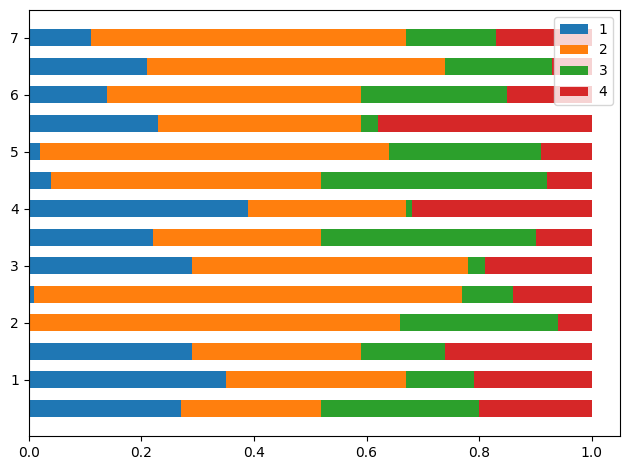

In [7]:
fig, ax = plt.subplots(tight_layout=True)

d_grpby = d_agg.groupby("value")
for group in d_grpby.groups:
    data = d_grpby.get_group(group)
    ax.barh("y", width="pct", left="x_left", data=data, height=.3, label=group)

ax.legend()
plt.show()

Sau khi đã hiểu được cách vẽ stacked bar chart bằng Pyplot, chúng ta sẽ bắt đầu với việc căn lại các thanh. Quan sát lại bảng thống kê ở trên, chúng ta thấy rằng cần phải đưa `x_left` của lựa chọn 3 của tất cả các câu hỏi về 0. Và `x_left` của lựa chọn 3 chính là tỉ lệ phần trăm tích lũy của các lựa chọn nhỏ hơn 3.

In [8]:
d_agg["pct_before_zero"] = d_agg["pct"].mask(d_agg["value"].ge(3), 0)
d_agg.head()

,sex,habit,value,n,sum,pct,x_right,x_left,habit_no,y,pct_before_zero
0,Nam,habit_1,1,27,100,0.27,0.27,0.00,1,0.5,0.27
1,Nam,habit_1,2,25,100,0.25,0.52,0.27,1,0.5,0.25
2,Nam,habit_1,3,28,100,0.28,0.80,0.52,1,0.5,0.00
3,Nam,habit_1,4,20,100,0.20,1.00,0.80,1,0.5,0.00
4,Nam,habit_2,1,29,100,0.29,0.29,0.00,2,1.5,0.29


In [9]:
d_agg["x_left_aligned"] = d_agg["x_left"] - \
    d_agg.groupby(["sex", "habit"])["pct_before_zero"].transform("sum")
d_agg.head()

,sex,habit,value,n,sum,pct,x_right,x_left,habit_no,y,pct_before_zero,x_left_aligned
0,Nam,habit_1,1,27,100,0.27,0.27,0.00,1,0.5,0.27,-0.52
1,Nam,habit_1,2,25,100,0.25,0.52,0.27,1,0.5,0.25,-0.25
2,Nam,habit_1,3,28,100,0.28,0.80,0.52,1,0.5,0.00,0.00
3,Nam,habit_1,4,20,100,0.20,1.00,0.80,1,0.5,0.00,0.28
4,Nam,habit_2,1,29,100,0.29,0.29,0.00,2,1.5,0.29,-0.59


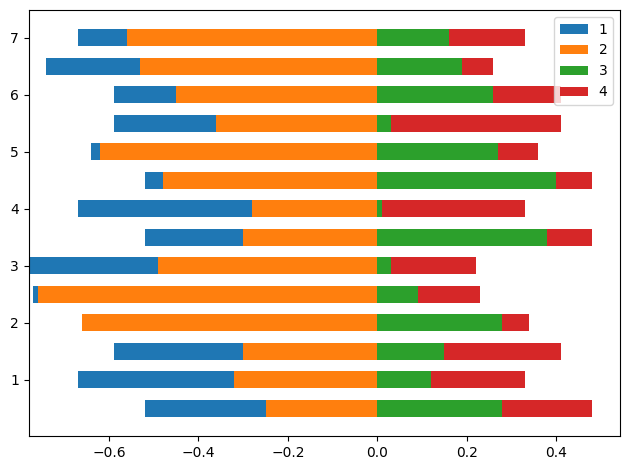

In [10]:
fig, ax = plt.subplots(tight_layout=True)

d_grpby = d_agg.groupby("value")
for group in d_grpby.groups:
    data = d_grpby.get_group(group)
    ax.barh("y", width="pct", left="x_left_aligned", data=data, height=.3, label=group)

ax.legend()
plt.show()

Tiếp theo, chúng ta sẽ tính toán giá trị của `y` để cho các nhóm nam và nữ gần lại nhau. Cách làm như sau:

* Các câu hỏi giống nhau sẽ có cùng một giá trị `y` ban đầu.
* Sau đó, cộng hoặc trừ giá trị `y` này với một con số tùy thuộc vào giới tính.

Con số mà chúng ta sẽ cộng thêm hoặc trừ đi cần được tính toán. Nếu các giá trị `y` ban đầu là 1, 2, 3, ... thì hai câu hỏi liên tiếp sẽ cách nhau 1 đơn vị. Nếu chiều cao (`height`) của mỗi thanh biểu đồ là 0.3 và khoảng cách giữa hai thanh biểu đồ của hai giới trong cùng một câu hỏi là 0.1, con số cộng/trừ sẽ là (0.3 + 0.1) / 2 = 0.2.

In [11]:
# sex == "Nam": 1 x 2 - 1 = 1
# sex == "Nữ" : 0 x 2 - 1 = -1
d_agg["y"] = d_agg["habit_no"] + 0.2 * d_agg["sex"].eq("Nam").mul(2).subtract(1)
d_agg.head()

,sex,habit,value,n,sum,pct,x_right,x_left,habit_no,y,pct_before_zero,x_left_aligned
0,Nam,habit_1,1,27,100,0.27,0.27,0.00,1,1.2,0.27,-0.52
1,Nam,habit_1,2,25,100,0.25,0.52,0.27,1,1.2,0.25,-0.25
2,Nam,habit_1,3,28,100,0.28,0.80,0.52,1,1.2,0.00,0.00
3,Nam,habit_1,4,20,100,0.20,1.00,0.80,1,1.2,0.00,0.28
4,Nam,habit_2,1,29,100,0.29,0.29,0.00,2,2.2,0.29,-0.59


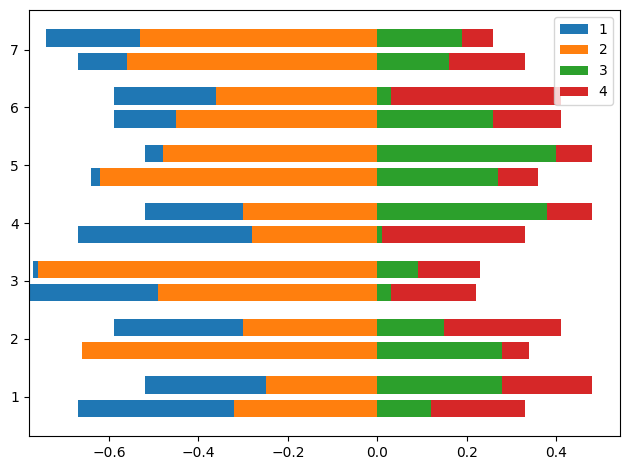

In [12]:
fig, ax = plt.subplots(tight_layout=True)

d_grpby = d_agg.groupby("value")
for group in d_grpby.groups:
    data = d_grpby.get_group(group)
    ax.barh("y", width="pct", left="x_left_aligned", data=data, height=.3, label=group)

ax.legend()
plt.show()

Một vấn đề nữa bạn có thể đã phát hiện ra là chúng ta không phân biệt được đâu là nam, đâu là nữ. Hãy cho nam giới mờ hơn nữ giới một chút bằng cách thay đổi alpha. Chúng ta cũng sẽ đảo ngược trục Y để câu hỏi về thói quen đầu tiên nằm ở trên cùng.

In [13]:
d_agg["alpha"] = d_agg["sex"].eq("Nam").map({True: .4, False: 1})
d_agg.head()

,sex,habit,value,n,sum,pct,x_right,x_left,habit_no,y,pct_before_zero,x_left_aligned,alpha
0,Nam,habit_1,1,27,100,0.27,0.27,0.00,1,1.2,0.27,-0.52,0.4
1,Nam,habit_1,2,25,100,0.25,0.52,0.27,1,1.2,0.25,-0.25,0.4
2,Nam,habit_1,3,28,100,0.28,0.80,0.52,1,1.2,0.00,0.00,0.4
3,Nam,habit_1,4,20,100,0.20,1.00,0.80,1,1.2,0.00,0.28,0.4
4,Nam,habit_2,1,29,100,0.29,0.29,0.00,2,2.2,0.29,-0.59,0.4


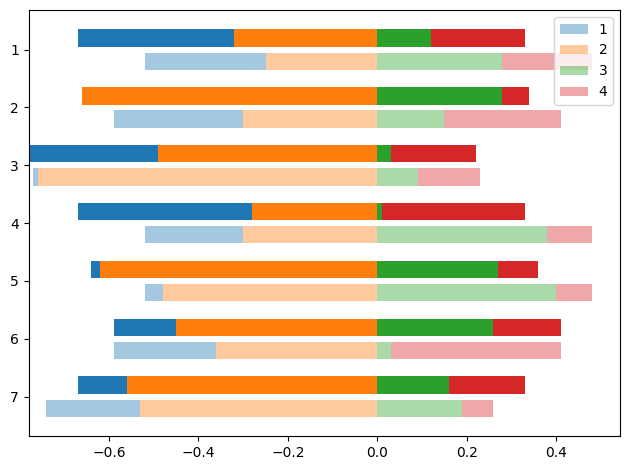

In [14]:
fig, ax = plt.subplots(tight_layout=True)
cmap = plt.get_cmap("tab10")  # Lấy bảng màu tab10

d_grpby = d_agg.groupby("value")
for group in d_grpby.groups:
    data = d_grpby.get_group(group)
    colors = cmap([(group - 1) / 10] * data.shape[0], data["alpha"])  # Lấy thông tin màu cho từng thanh
    ax.barh("y", width="pct", left="x_left_aligned", data=data, height=.3,
            color=colors, label=group)

ax.legend()
ax.invert_yaxis()
plt.show()

Công việc còn lại sẽ là thêm nhãn, định dạng lại các trục tọa độ và chú thích, và "làm đẹp" cho biểu đồ.

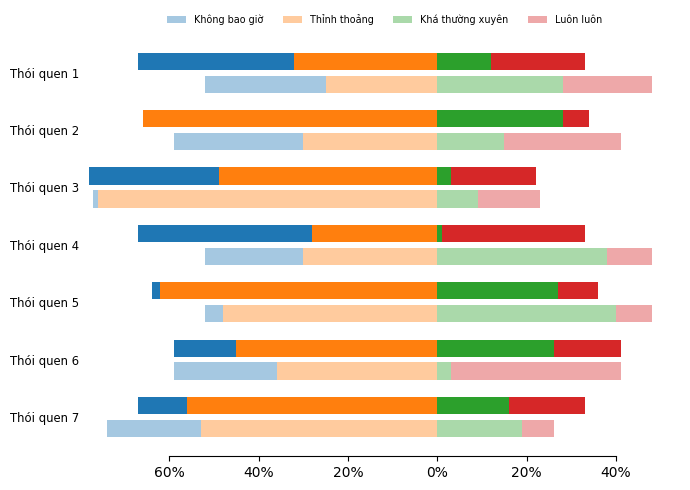

In [15]:
labels = {
    1: "Không bao giờ",
    2: "Thỉnh thoảng",
    3: "Khá thường xuyên",
    4: "Luôn luôn"
}
ytick_labels = [f"Thói quen {i}" for i in range(1, 8)]

fig, ax = plt.subplots(figsize=(7, 5), tight_layout=True)
cmap = plt.get_cmap("tab10")  # Lấy bảng màu tab10

d_grpby = d_agg.groupby("value")
for group in d_grpby.groups:
    data = d_grpby.get_group(group)
    colors = cmap([(group - 1) / 10] * data.shape[0], data["alpha"])  # Lấy thông tin màu cho từng thanh
    ax.barh("y", width="pct", left="x_left_aligned", data=data, height=.3,
            color=colors, label=labels[group])

ax.invert_yaxis()
ax.set_yticks(range(1, 8), ytick_labels, fontsize="small")
ax.yaxis.set_ticks_position("none")

ax.xaxis.set_major_formatter(lambda x, pos: f"{abs(x):.0%}")

ax.legend(frameon=False, fontsize="x-small", ncols=4,
          loc="lower center", bbox_to_anchor=(.5, 1))

ax.spines[["left", "top", "right"]].set_visible(False)
ax.spines["bottom"].set_bounds(-.6, .4)

plt.show()

---

[Bài trước](./10_pvalue.ipynb) - [Danh sách bài](../README.md) - [Bài sau]()